# Rock, paper, scissors convolutional model

our goal is to construct a model for the popular game of Rock, Paper, Scissors. This game predominantly revolves around the choices made by players, specifically between scissors, rock, or paper. This characteristic enables us to employ image classification techniques to effectively model the game.

 our approach involves capturing the hand gestures of the player and predicting whether they represent rock, paper, or scissors. Subsequently, the computer will make a random selection, leading to a determination of the winner.

As part of our methodology, we utilized the TensorFlow Datasets library, which offers of datasets seamlessly compatible with TensorFlow. For the construction of our model, we made use of the rock paper scissors dataset readily available within the TensorFlow library.
  
It is worth to mention that we get the idea from the tensorflow dataset and the following notebook, but we built our own model to implement image classification.  
  
https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_cnn/rock_paper_scissors_cnn.ipynb#scrollTo=DJ8jGFnTLt8t

### Un-comment and run if your environment is missing tensorflow datasets package.

In [393]:
# ! pip install tensorflow_datasets

In [394]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [395]:
# Load the Rock Paper Scissors dataset
dataset = tfds.load('rock_paper_scissors')

# Split the dataset into training and testing sets
train_dataset = dataset['train']
test_dataset = dataset['test']

### Data Exploration:

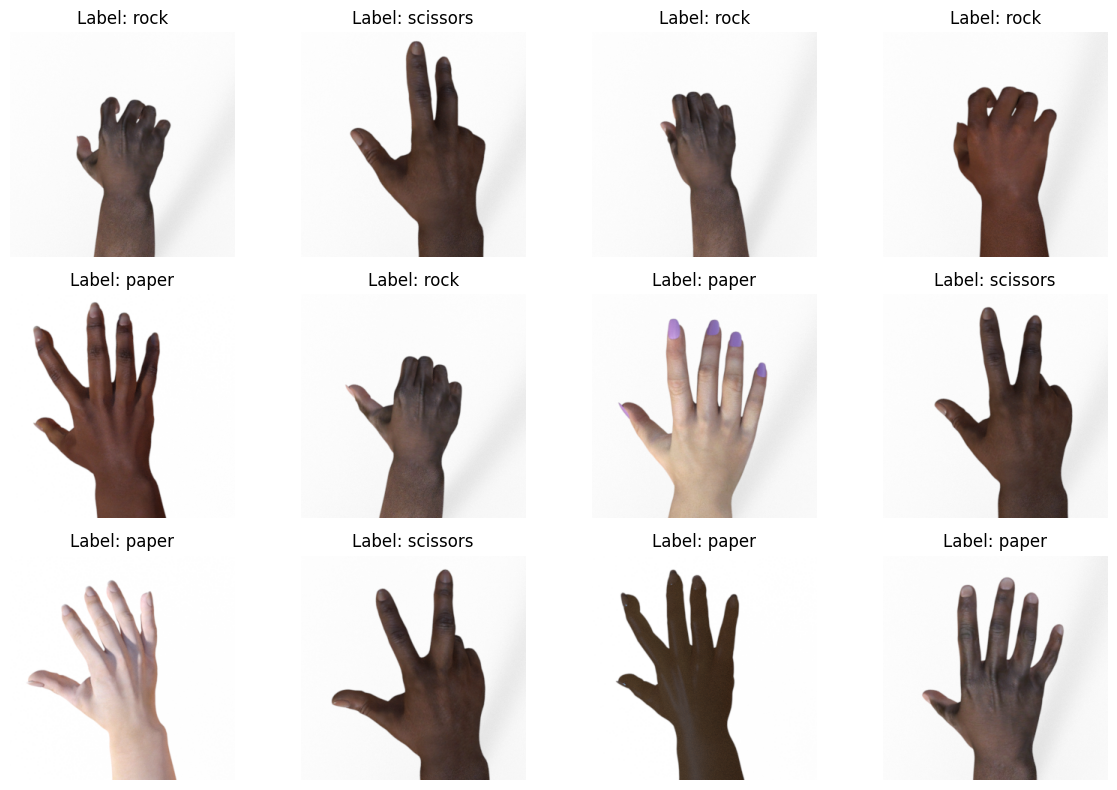

In [396]:
# Define the label names
label_names = ['rock', 'paper', 'scissors']

# Take 12 random samples from the training dataset
num_samples = 12
samples = train_dataset.shuffle(1000).take(num_samples)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

# Iterate over the samples and plot the images
for i, data in enumerate(samples):
    image = data['image']
    label = data['label']

    # Convert the image tensor to a NumPy array
    image_array = tf.image.convert_image_dtype(image, tf.uint8).numpy()

    # Calculate the subplot position
    row = i // 4
    col = i % 4

    # Plot the image in the corresponding subplot
    axes[row, col].imshow(image_array)
    axes[row, col].set_title(f"Label: {label_names[label.numpy()]}")
    axes[row, col].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Pre-Process data

In [397]:
def preprocess_image(data):
    image = tf.image.resize(data['image'], (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    label = data['label']
    return image, label

train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [398]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [399]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 16)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 63504)             0         
                                                                 
 dropout_15 (Dropout)        (None, 63504)             0         
                                                                 
 dense_30 (Dense)            (None, 32)                2032160   
                                                                 
 dense_31 (Dense)            (None, 3)                 99        
                                                     

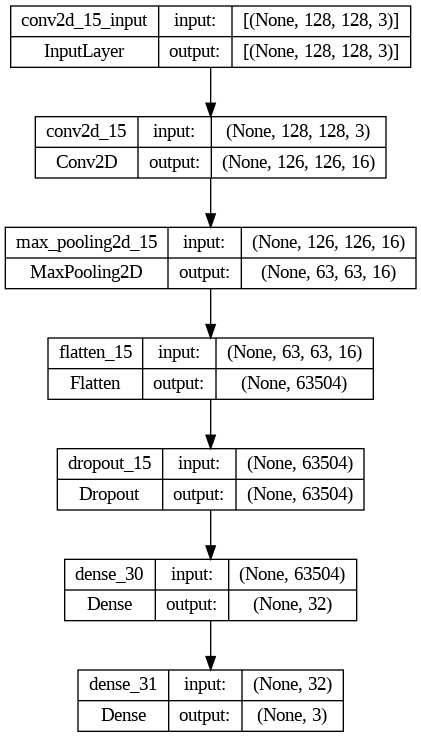

In [400]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [401]:
# we can also add learning rate to optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile cnn model
model.compile(optimizer= adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [402]:

# Train cnn mmodel
model.fit(train_dataset, epochs=10)

Epoch 1/10
79/79 [==============================] - 8s 84ms/step - loss: 1.3487 - accuracy: 0.5643
Epoch 2/10
79/79 [==============================] - 1s 12ms/step - loss: 0.4452 - accuracy: 0.9115
Epoch 3/10
79/79 [==============================] - 1s 19ms/step - loss: 0.2097 - accuracy: 0.9734
Epoch 4/10
79/79 [==============================] - 2s 21ms/step - loss: 0.0901 - accuracy: 0.9901
Epoch 5/10
79/79 [==============================] - 1s 13ms/step - loss: 0.0494 - accuracy: 0.9952
Epoch 6/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0311 - accuracy: 0.9972
Epoch 7/10
79/79 [==============================] - 1s 13ms/step - loss: 0.0220 - accuracy: 0.9980
Epoch 8/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0160 - accuracy: 0.9984
Epoch 9/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0117 - accuracy: 0.9984
Epoch 10/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0108 - accuracy: 0.9988


In [403]:
# Evaluate cnn model
model.evaluate(test_dataset)

12/12 [==============================] - 1s 85ms/step - loss: 0.7372 - accuracy: 0.7151


[0.737231433391571, 0.7150537371635437]

## Data Augmentation to improve overfitting and test accuracy.

### Fix overfitting by augmenting data. This include rotating images, flipping images, changing color, and zoom. Augmentations taken from: https://www.wouterbulten.nl/posts/data-augmentation-using-tensorflow-data-dataset/

In [404]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

In [405]:
def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

In [406]:
def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

In [407]:
def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

### Zoom not implemented. Need to fix error at a later point.

In [408]:
def augment_data(image, label):
    image = flip(image)
    image = color(image)
    image = rotate(image)
    #image = zoom(image)
    return image, label

In [409]:
train_dataset_augmented = train_dataset.map(augment_data)

### Explore new augmented dataset

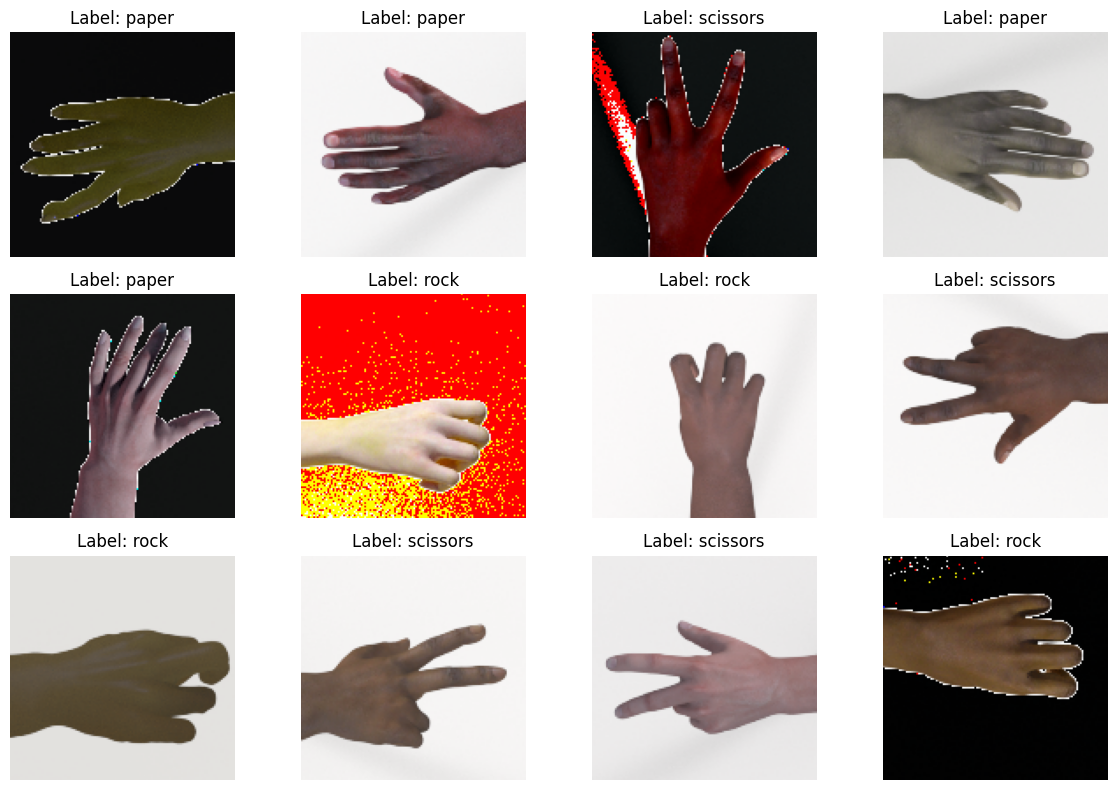

In [410]:
# Explore augmented training dataset.

# Take 12 random samples from the augmented training dataset
num_samples = 12
samples = train_dataset_augmented.shuffle(1000).take(num_samples)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

# Iterate over the samples and plot the images
for i, (image, label) in enumerate(samples):
    # Select a single image from the batch
    image = image[0]

    # Convert the image tensor to a NumPy array
    image_array = tf.image.convert_image_dtype(image, tf.uint8).numpy()

    # Calculate the subplot position
    row = i // 4
    col = i % 4

    # Plot the image in the corresponding subplot
    axes[row, col].imshow(image_array)
    axes[row, col].set_title(f"Label: {label_names[label[0].numpy()]}")
    axes[row, col].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Shuffle and batch the datasets so a few samples from each is taken for training.

In [411]:
def preprocess_image_augmented(image,label):
    image = tf.image.resize(data['image'], (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    label = data['label']
    return image, label

train_dataset_augmented = train_dataset_augmented.map(preprocess_image_augmented)
train_dataset_augmented = train_dataset_augmented.batch(32).prefetch(tf.data.AUTOTUNE)

In [412]:
# combine the datasets
# Combine the augmented and original training datasets
combined_train_dataset = train_dataset_augmented.concatenate(train_dataset)

# Shuffle the combined dataset
#combined_train_dataset = combined_train_dataset.shuffle(1000)

# Batch and prefetch the combined dataset
#combined_train_dataset = combined_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [413]:
# Shuffle and batch the datasets
#batch_size = 32
#train_dataset_augmented = train_dataset_augmented.shuffle(1000).batch(batch_size)
#train_dataset = train_dataset.shuffle(1000).batch(batch_size)
#test_dataset = test_dataset.shuffle(1000).batch(batch_size)

In [414]:
# Train the model using the combined dataset
epochs = 10
#train_dataset_augmented_shuffled
history = model.fit(combined_train_dataset, epochs=epochs, verbose=1, validation_data=test_dataset)

Epoch 1/10
82/82 [==============================] - 4s 31ms/step - loss: 0.0065 - accuracy: 0.9992 - val_loss: 0.6908 - val_accuracy: 0.7392
Epoch 2/10
82/82 [==============================] - 4s 33ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.6810 - val_accuracy: 0.7446
Epoch 3/10
82/82 [==============================] - 5s 39ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.7817 - val_accuracy: 0.7419
Epoch 4/10
82/82 [==============================] - 4s 31ms/step - loss: 0.0048 - accuracy: 0.9996 - val_loss: 0.6913 - val_accuracy: 0.7419
Epoch 5/10
82/82 [==============================] - 3s 30ms/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.7753 - val_accuracy: 0.7339
Epoch 6/10
82/82 [==============================] - 5s 42ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.8699 - val_accuracy: 0.7258
Epoch 7/10
82/82 [==============================] - 4s 32ms/step - loss: 0.0047 - accuracy: 0.9996 - val_loss: 0.7700 - val_accuracy: 0.7500
Epoch 8/10
82

In [415]:
# Evaluate cnn model
model.evaluate(test_dataset)

12/12 [==============================] - 0s 10ms/step - loss: 0.8929 - accuracy: 0.7285


[0.8929280638694763, 0.7284946441650391]

In [416]:
# save cnn model
model_name = 'rock_paper_scissors_cnn.h5'
model.save(model_name, save_format='h5')

### Graphs on model accuracy

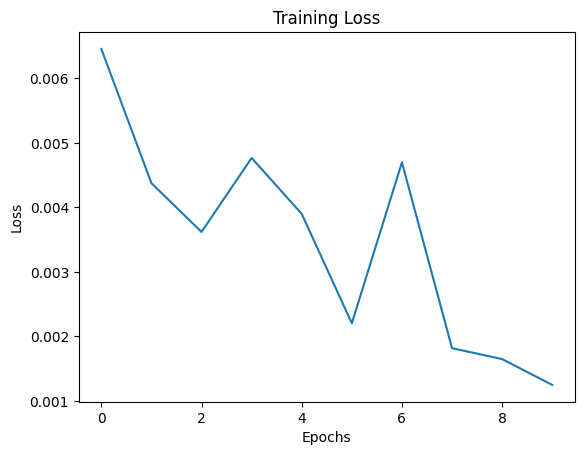

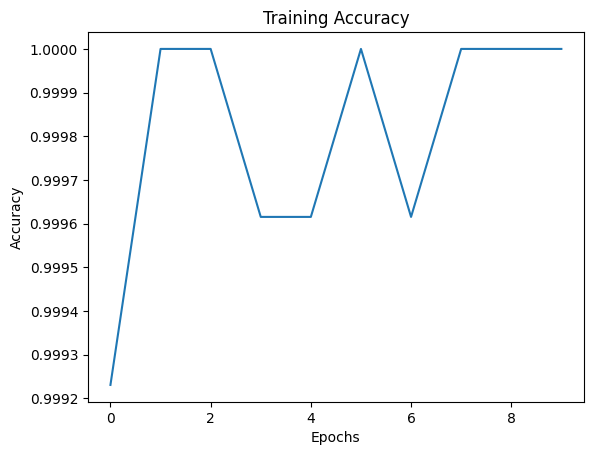

In [417]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot the training accuracy
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

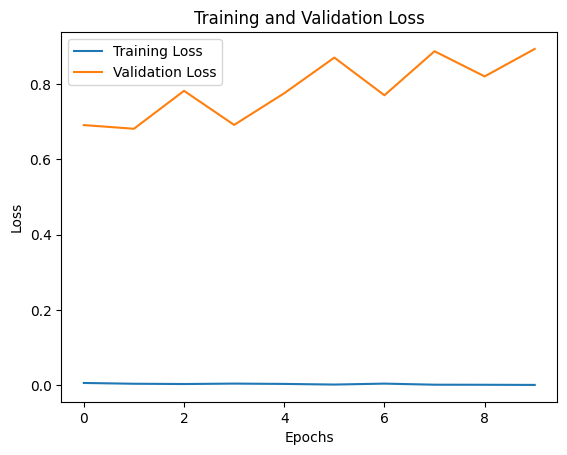

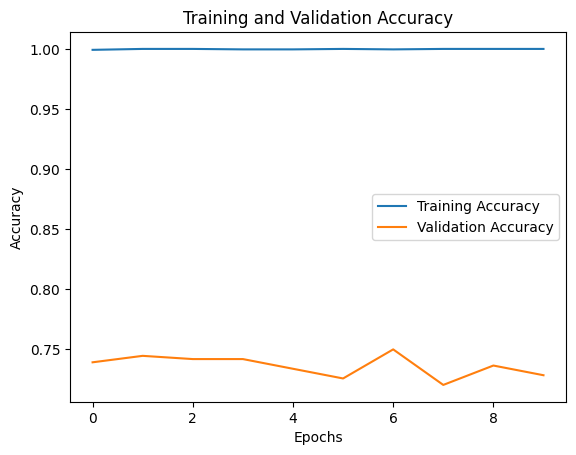

In [418]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()